<h3>Step 1: Retrieve data from REST API and create dataframe</h3>

In [19]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
'''
response = requests.get('http://localhost:8080/medish_centrum_randstad/api/netlify')
print(type(response))

file_contents= response.json()  #dictionary
print(type(file_contents))
print(len(file_contents))

og_df = pd.DataFrame.from_dict(file_contents['data']) #all the needed info was condensed into one data column called 'data'
display(og_df.head())
display(og_df.shape)
'''

og_df = pd.read_csv('lifespan.csv', header=0, sep=',',skipinitialspace=True) 

In [20]:
og_df.head()

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
0,84.0,180.0,90.0,2.0,9.0,1.0,2,86
1,84.0,204.0,79.0,3.0,2.0,7.0,3,100
2,84.0,174.0,74.0,3.0,20.0,3.0,2,87
3,84.0,187.0,78.0,2.0,6.0,5.0,3,91
4,84.0,187.0,89.0,2.0,12.0,0.0,2,83


In [21]:
# og_df.to_csv('lifespan.csv', index=False)

In [22]:
og_df.info
og_df.describe()  #mean,sd, min,max

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
count,8191.000000,8190.000000,8191.000000,8191.000000,8191.000000,8191.000000,8192.000000,8192.000000
mean,79.967770,183.642735,79.794286,1.617141,9.773776,5.748260,2.423340,76.096069
std,1.634992,12.600441,12.076801,0.830975,6.967164,2.664489,0.950095,10.918167
min,76.000000,154.000000,60.000000,0.000000,0.000000,0.000000,1.000000,40.000000
25%,79.000000,174.000000,70.000000,1.000000,3.000000,4.000000,2.000000,68.000000
50%,80.000000,183.000000,79.000000,1.000000,10.000000,6.000000,2.000000,76.000000
75%,81.000000,193.000000,88.000000,2.000000,16.000000,8.000000,3.000000,83.000000
max,84.000000,214.000000,112.000000,4.000000,22.000000,10.000000,5.000000,113.000000


<h3> Step 2: Exploratory Data Analysis </h3>
- null values check <br>
- duplicates check

In [23]:
analysis_df = og_df.copy()
analysis_df.isnull().sum()
#why is it missing, is it random? : input (impute) or delete?

genetic     1
length      2
mass        1
exercise    1
smoking     1
alcohol     1
sugar       0
lifespan    0
dtype: int64

In [24]:
analysis_df.duplicated().sum()
# dupli_rows = df[df.duplicated()]
# df.drop.duplicates() 

0

Set lifespan (age influenced by lifestyle) as index

In [25]:
analysis_df = analysis_df.set_index('lifespan')
analysis_df = analysis_df.sort_index()
display(analysis_df.head())

,genetic,length,mass,exercise,smoking,alcohol,sugar
lifespan,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4
44,78.0,180.0,95.0,0.0,22.0,9.0,2
44,79.0,178.0,93.0,0.0,22.0,5.0,4
44,76.0,181.0,104.0,1.0,14.0,9.0,4
45,78.0,170.0,81.0,1.0,21.0,8.0,5


<h3> Lets zoom in on Alchohol specifically </h3>

In [26]:
alcohol_df = analysis_df[['alcohol','mass']].copy()
display(alcohol_df.head())
display(alcohol_df.isnull().sum())

,alcohol,mass
lifespan,,
40,8.0,96.0
44,9.0,95.0
44,5.0,93.0
44,9.0,104.0
45,8.0,81.0


alcohol    1
mass       1
dtype: int64

In [27]:
alcohol_df = alcohol_df.dropna()

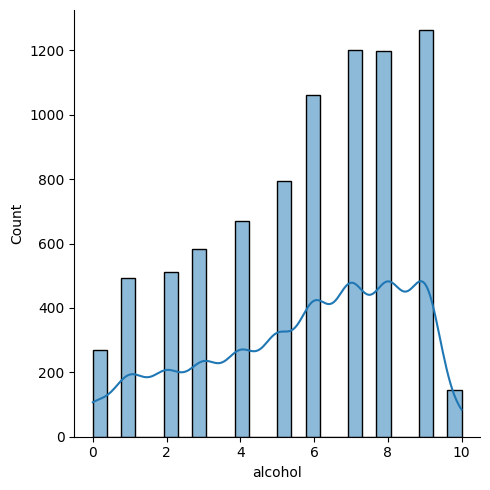

In [28]:
sns.displot(alcohol_df,x='alcohol',kde=True)

<Axes: >

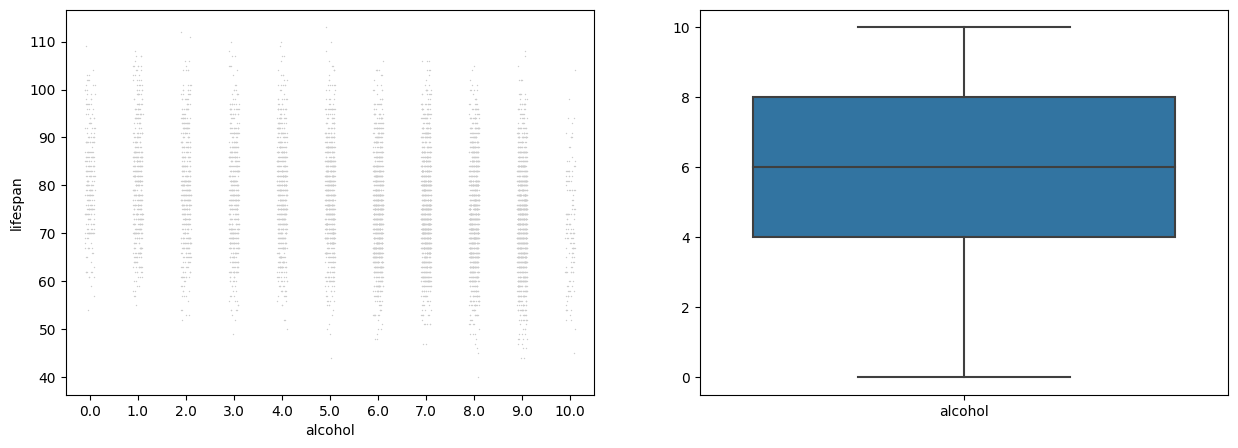

In [29]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.stripplot(alcohol_df, x='alcohol', y='lifespan',size=1, color=".8",ax=axes[0])
sns.boxplot(alcohol_df[['alcohol']],ax=axes[1])

With a mean of 5.75 and a sigma of 2.66 there are no significant outliers (more then 2 sigma)

<Axes: xlabel='alcohol', ylabel='lifespan'>

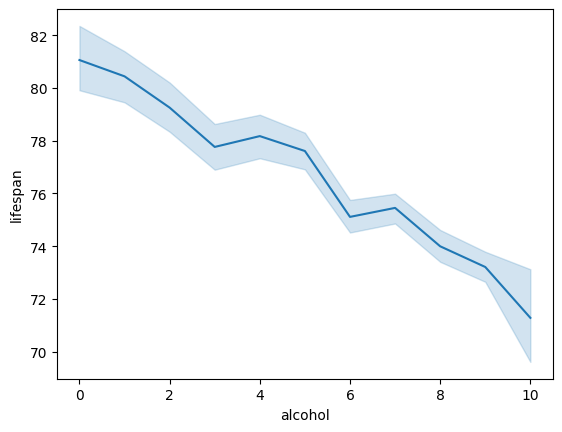

In [30]:
sns.lineplot(alcohol_df,x='alcohol',y='lifespan')

Alcohol looks to have a negative linear correlation 

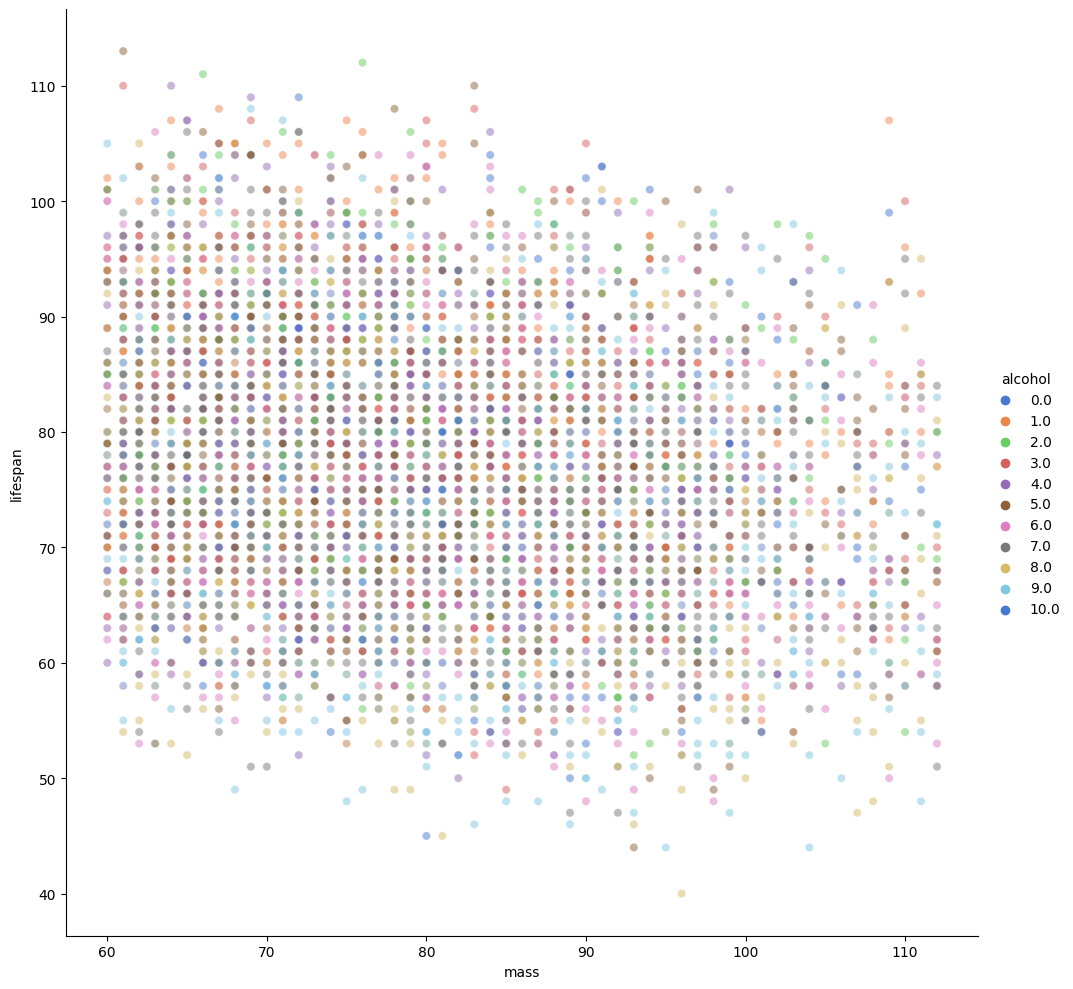

In [31]:
sns.relplot(x="mass", y="lifespan", hue="alcohol",
            sizes=(10, 400), alpha=.5, palette="muted",
            height=10, data=alcohol_df)

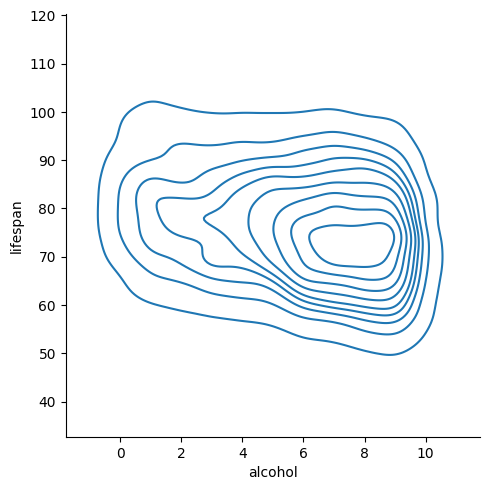

In [32]:
sns.displot(alcohol_df, x="alcohol", y="lifespan", kind="kde")

<h3>Imputing: Lets take a closer look at mass and replace missing values</h3>

In [33]:
temp = (analysis_df
        .loc[(analysis_df['mass']
              .isnull())]
              .copy()
)
display(temp)

,genetic,length,mass,exercise,smoking,alcohol,sugar
lifespan,,,,,,,
89,78.0,176.0,NaN,3.0,3.0,3.0,4


missing mass corresponds to a length of 176 <br>
for exercise sake lets substitute the missing value with the avg BMI for this length <br> (source: https://www.topendsports.com/testing/BMI-table.htm)<br>
this influences the standard deviation though, best way is to make a sub-model: where the mass is output(y) value and train a model that can predict the mass at a specific e.g. lenght for example

In [34]:
avg_bmi_174 = (62.0+77.4)/2
analysis_df.loc[(analysis_df['mass'].isnull()),'mass']=avg_bmi_174
tempdf = analysis_df.query('lifespan == 89')
#check if still null values
print(tempdf['mass'].isnull().sum())

0


Detect outliers with boxplots:

<Axes: xlabel='mass'>

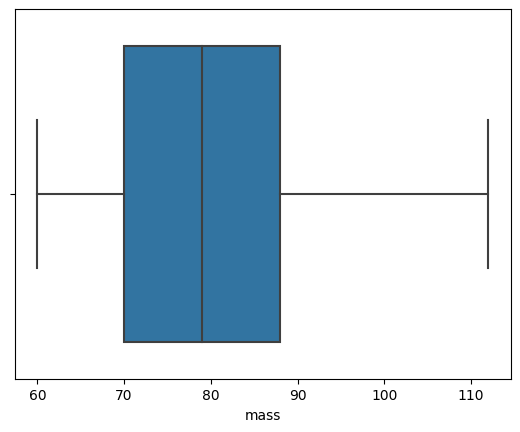

In [35]:
sns.boxplot(x=og_df['mass'])


In [36]:
Q1 = og_df['mass'].quantile(0.25)
Q3 = og_df['mass'].quantile(0.75)
print(Q1)
print(Q3)
IQR = Q3-Q1 #interquartilerange (delta)
print(IQR)
#if you are a distance of 1.5 times the IQR from Q1 down or Q3 up, outliers
# this is one way to do it, but analyse if this is the right way to do it

70.0
88.0
18.0


<h3>Step 3: Feature creation, understanding and relationships</h3>

Feature Engineering:
Let's introduce a new feature BMI which takes the mass divided by the square of the length and analyze its values (frequency, density estimation)

In [37]:
analysis_df['BMI'] = analysis_df['mass']/(analysis_df['length']/100)**2
display(analysis_df.head())

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI
lifespan,,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376
44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988
44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355
44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063
45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682


In [38]:
analysis_df['BMI'].value_counts().head(5)

19.576333    15
24.655910    15
23.629490    14
28.692653    14
22.014014    14
Name: BMI, dtype: int64

Text(0.5, 0, 'Body Mass Index, BMI (kg/m^2)')

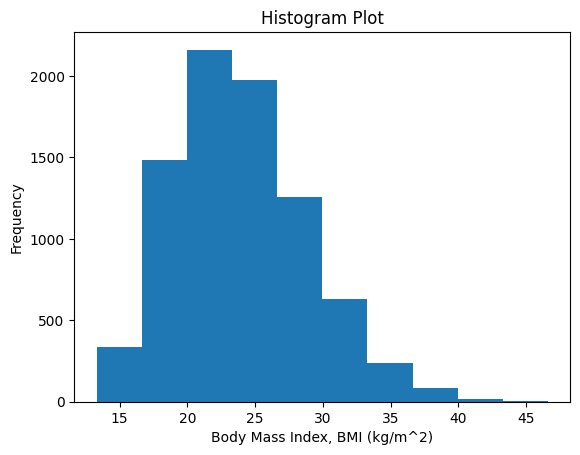

In [47]:
axes = analysis_df['BMI'].plot(kind='hist',bins=10,title='Histogram Plot')
axes.set_xlabel('Body Mass Index, BMI (kg/m^2)')

Text(0.5, 0, 'Body Mass Index, BMI (kg/m^2)')

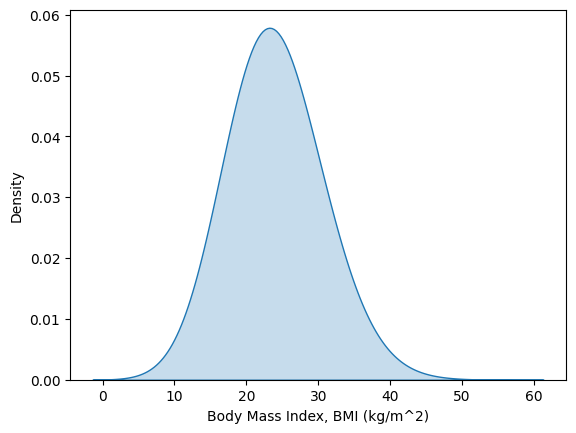

In [40]:
fig, ax = plt.subplots()

#ax1 = analysis_df['BMI'].plot(kind='kde', title='KDE Plot')

ax2 = sns.kdeplot(analysis_df['BMI'], fill=True, bw_method=1)
ax2.set_xlabel('Body Mass Index, BMI (kg/m^2)')

In [41]:
temp = analysis_df.reset_index().copy()
display(temp)

,lifespan,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI
0,40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376
1,44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988
2,44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355
3,44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063
4,45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682
...,...,...,...,...,...,...,...,...,...
8187,110,80.0,200.0,83.0,4.0,0.0,5.0,1,20.750000
8188,110,80.0,198.0,64.0,4.0,3.0,4.0,2,16.324865
8189,111,80.0,196.0,66.0,3.0,0.0,2.0,2,17.180342
8190,112,79.0,192.0,76.0,4.0,0.0,2.0,1,20.616319


Scatterplot of BMI and Lifespan

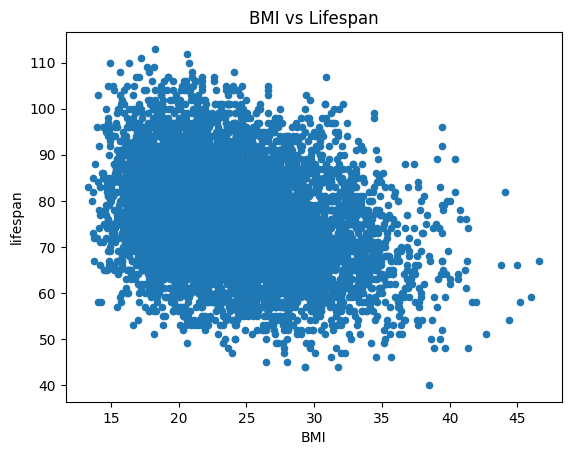

In [42]:
ax = temp.plot(kind='scatter', y='lifespan', x='BMI', title='BMI vs Lifespan')

It seems BMI alone is too general of an indicator for lifespan given the wide range of lifespans over different BMI levels, given the drawbacks of BMI: it does not account for body fat percentage or body fat distribution this makes sense

Scatterplot with SNS adding smoking as differentiator by color/hue between points <br>
here you can see that smoking lowers lifespan across all BMI values and seems to be a better indicator for lifespan

<Axes: xlabel='BMI', ylabel='lifespan'>

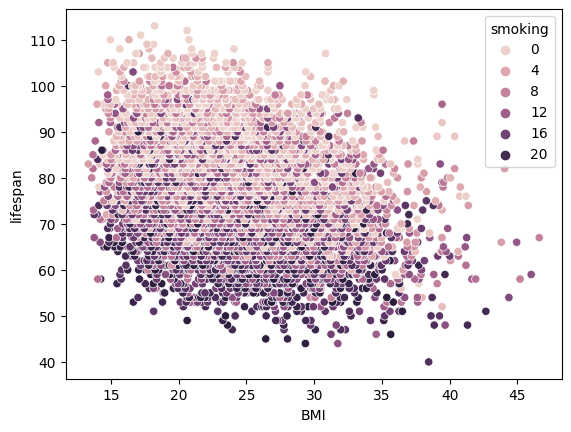

In [43]:
sns.scatterplot(data=temp, x='BMI',y='lifespan', hue='smoking') 



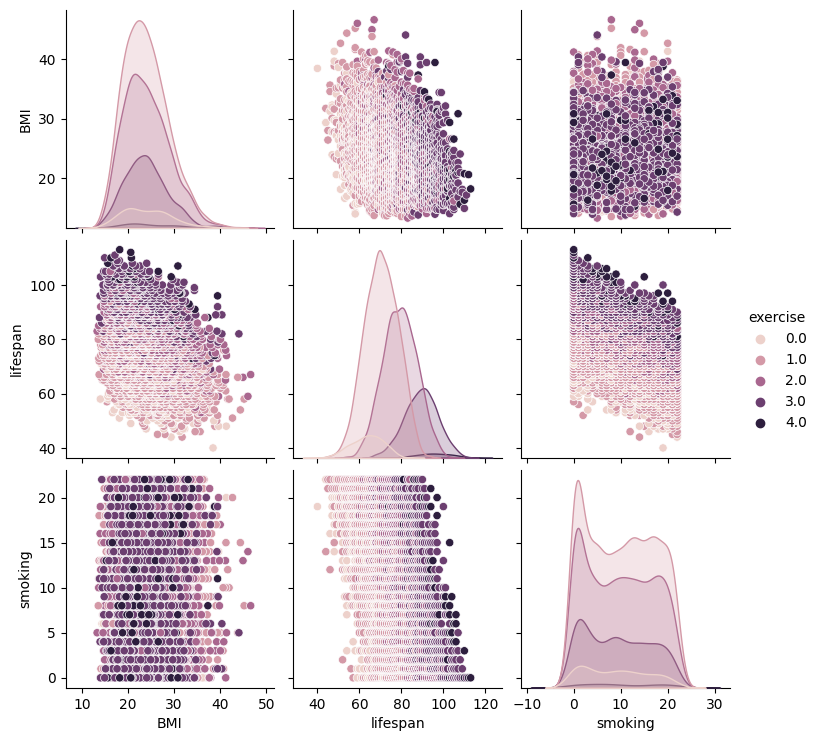

In [44]:
sns.pairplot(data=temp,vars=['BMI','lifespan','smoking'], hue='exercise')

In [45]:
temp.columns

Index(['lifespan', 'genetic', 'length', 'mass', 'exercise', 'smoking',
       'alcohol', 'sugar', 'BMI'],
      dtype='object')

AttributeError: module 'seaborn' has no attribute 'jitterplot'

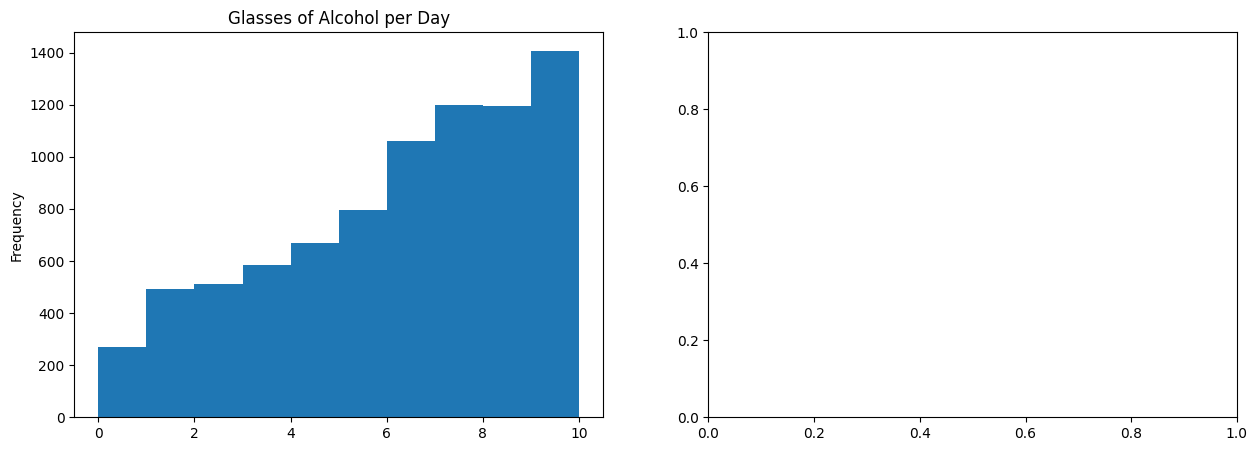

In [46]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

temp['alcohol'].plot(kind='hist', ax = axes[0], title = 'Glasses of Alcohol per Day')
sns.jitterplot(temp, x='alcohol',y='lifespan',ax = axes[1])

<h3> Step 4: Correlations of independent variables with dependent variable lifespan</h3>

__[Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__

$ \rho_{x,y} = \frac{cov(x,y)}{\sigma_{x}\sigma{y}}$



In [ ]:
df_corr = temp[['lifespan', 'genetic', 
      #'length', 'mass', 
      'exercise', 'smoking',
       'alcohol', 'sugar', 'BMI']].dropna().corr()
df_corr.style.background_gradient(cmap='RdBu')

,lifespan,genetic,exercise,smoking,alcohol,sugar,BMI
lifespan,1.000000,0.151944,0.677432,-0.525678,-0.216934,-0.263588,-0.276982
genetic,0.151944,1.000000,0.004218,-0.010887,0.003763,-0.006869,-0.008239
exercise,0.677432,0.004218,1.000000,-0.012952,0.005744,-0.008909,0.005216
smoking,-0.525678,-0.010887,-0.012952,1.000000,0.001535,-0.001565,0.019533
alcohol,-0.216934,0.003763,0.005744,0.001535,1.000000,0.013651,-0.006216
sugar,-0.263588,-0.006869,-0.008909,-0.001565,0.013651,1.000000,0.014166
BMI,-0.276982,-0.008239,0.005216,0.019533,-0.006216,0.014166,1.000000


<Axes: >

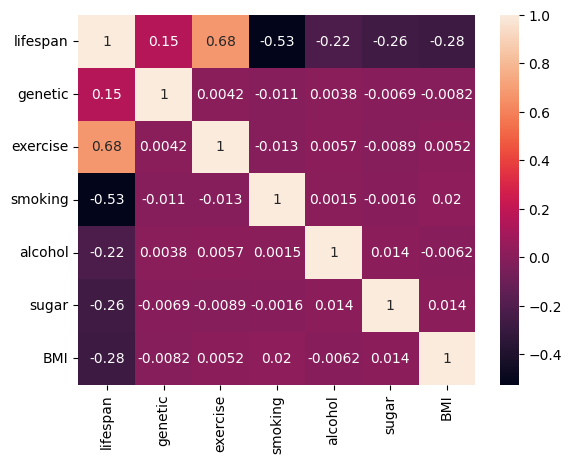

In [ ]:
sns.heatmap(df_corr,annot=True)
#basically graphical correlation matrix view

#Calculate P-values

In [ ]:
import numpy as np
from scipy import stats

temp = temp.dropna()
r,p = stats.pearsonr(temp.lifespan,temp.smoking)
print('smoking corr:',round(r,4))
print('smoking p-val:',round(p,4))
r,p = stats.pearsonr(temp.lifespan,temp.exercise)
print('exercise corr:',round(r,4))
print('exercise p-val:',round(p,4))
r,p = stats.pearsonr(temp.lifespan,temp.genetic) #capital sensitive .<columnname>
print('BMI corr:',round(r,4))
print('BMI p-val:',round(p,4))

smoking corr: -0.5257
smoking p-val: 0.0
exercise corr: 0.6774
exercise p-val: 0.0
BMI corr: 0.1519
BMI p-val: 0.0


This means that the correlation for smoking(-0.5257) with a p<0.05 (almost 0) is extremely likely to happen again if we collect more sample data and thus representative for the entire set


Biggest influence on lifespan is exercise with a positive correlation and smoking with a negative correlation <br><br>
&emsp;&emsp;&emsp;   $\rho_{exercise,lifespan}=+0.677$ <br>
&emsp;&emsp;&emsp;   $\rho_{exercise,smoking}=-0.52$ <br><br>
Ideally you want these values to be 1/-1 to have a linear correlation <br>
unsure if in this case with these values you can assume linearity but lets look at the graphs:

Checking distribution / continuity

<Axes: xlabel='exercise', ylabel='Count'>

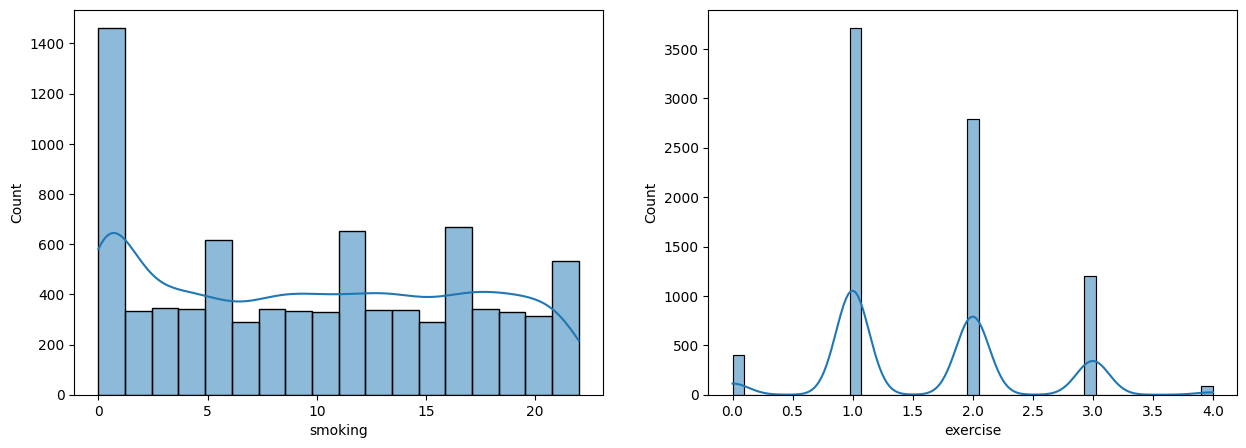

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(temp,x='smoking',kde=True, ax=axes[0])
sns.histplot(temp,x='exercise',kde=True, ax=axes[1])

<Axes: xlabel='exercise', ylabel='lifespan'>

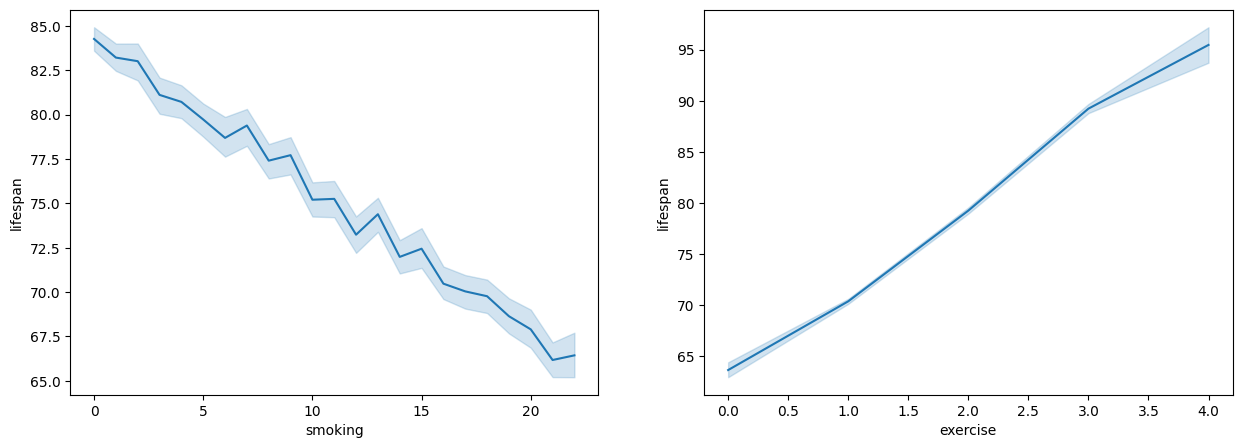

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(temp,x='smoking',y='lifespan', ax=axes[0])
sns.lineplot(temp,x='exercise',y='lifespan',ax=axes[1])

<h3>Step 5: Looks decently linear, lets continue to predict lifespan using multivariable linear regression</h3>
- Inputs: Smoking, Exercise<br>
- Output: Lifespan<br>

$ y=\alpha*x_{smoking}+\beta*x_{exercise}+c $

In [ ]:
from sklearn import linear_model 
from sklearn.model_selection import train_test_split

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# Heading

In [ ]:
temp = temp.dropna().copy()

train, test = train_test_split(temp, test_size=0.2, random_state=0)

X = train[['smoking', 'exercise']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 

LinearRegression()

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print(f'c would be:',regr.predict([[0,0]]))

Coefficients: 
 [-0.80486704  8.83925385]
c would be: [69.69580671]


d:\0_Program_Files\Python3.10.1\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
def prediction(cigarettes, exercise):
    coef = regr.coef_
    intercept = regr.predict([[0,0]])
    return (coef[0]*cigarettes+coef[1]*exercise+intercept)

In [ ]:
prediction(0,0.25)

d:\0_Program_Files\Python3.10.1\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([71.90562017])

In [ ]:
print(train.shape, test.shape)
score = regr.score(test[['smoking', 'exercise']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}):', score)

(6548, 9) (1638, 9)
coefficient of determination(R²): 0.7199784673426635


In regression, the $R^{2}$ coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points.  <br>
In this case a $R^{2}$ at 0.72 shows a decent correlation between the independent variables smoking, exercise and the dependent variable lifespan.

The dataset contains some features which are categorical variables and some which are continuous, Variable Decision Tree might produce better results

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

In [ ]:
rng_forest_regr = RandomForestRegressor(n_estimators=100)
rng_forest_regr.fit(X,y)

RandomForestRegressor()

In [ ]:
rng_forest_score = rng_forest_regr.score(test[['smoking', 'exercise']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}):', rng_forest_score)

coefficient of determination(R²): 0.7151181461891603


similar result as with linear regression

<h3>Step 6: Calculate the PremiumFactor for the insurance </h3><br>

$ PremiumFactor=\frac{genetic}{lifespan} $

In [ ]:
# lets calculate for a person of 60, no smoking and 1 hour of exercise a day
age = 75
print(f'Predicted lifespan for no smoking and 1 hour of exercise a day:', regr.predict([[0,0]]))
print(f'PremiumFactor=', age/regr.predict([[0,0]]))


Predicted lifespan for no smoking and 1 hour of exercise a day: [69.69580671]
PremiumFactor= [1.07610491]


d:\0_Program_Files\Python3.10.1\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\0_Program_Files\Python3.10.1\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


The premiumfactor for a 75 year old with a predicted lifespan of 69.7 equals 1.076 <br>
meaning he has to pay 7.6% extra on his life insurance <br>